### This Notebook is used to make time lagged composites of TTT Events to identify important features/regions that could be used in predicting the value of my TTT Index on that day

In [1]:
# Imports go here
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import os
from PIL import Image
import datetime as dt
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
import matplotlib as mpl
import glob
from matplotlib.offsetbox import AnchoredText
import matplotlib.patches as mpatches

mpl.rcParams['savefig.dpi'] = 350
mpl.rcParams['savefig.facecolor'] = 'white'
mpl.rcParams['savefig.bbox'] = 'tight'


In [2]:
# paths go here
root = os.getcwd()
data_path = root + '/DATA'
figure_path = root + '/FIGURES/'

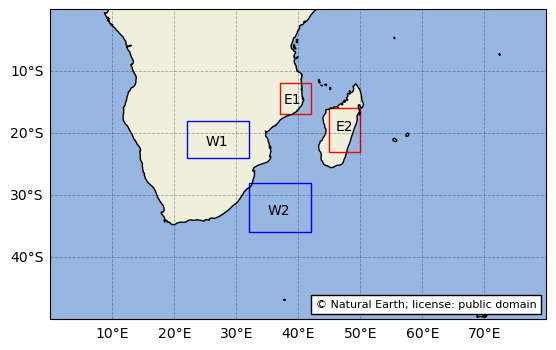

In [3]:
#make a plot to show the regions over which the index is calculated
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
#ax.stock_img()

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)

# Add a text annotation for the license information to the
# the bottom right corner.
text = AnchoredText('\u00A9 {}; license: {}'
                    ''.format(SOURCE, LICENSE),
                    loc=4, prop={'size': 8}, frameon=True)
ax.add_artist(text)

#add in the boxes
#E1
ax.add_patch(mpatches.Rectangle(xy=[37, -17], width=5, height=5,
                                facecolor='none', edgecolor='r',
                                transform=ccrs.PlateCarree()))
ax.text(37.6,-15.2,'E1')
#E2
ax.add_patch(mpatches.Rectangle(xy=[45, -23], width=5, height=7,
                                facecolor='none', edgecolor='r',
                                transform=ccrs.PlateCarree()))
ax.text(46,-19.5,'E2')
#W1
ax.add_patch(mpatches.Rectangle(xy=[22, -24], width=10, height=6,
                                facecolor='none', edgecolor='b',
                                transform=ccrs.PlateCarree()))
ax.text(25,-22,'W1')
#W2
ax.add_patch(mpatches.Rectangle(xy=[32, -36], width=10, height=8,
                                facecolor='none', edgecolor='b',
                                transform=ccrs.PlateCarree()))
ax.text(35,-33,'W2')



ax.set_xlim(0,80)
ax.set_ylim(-50,0)
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_BOXES.png')
plt.show()

In [4]:
#load in the data from my TTT Index to find TTT days
os.chdir(data_path)
ttt_file_data = np.loadtxt('TTT_Index.csv',skiprows=1,delimiter=',')
os.chdir(root)
ttt_year = ttt_file_data[:,0]
ttt_month = ttt_file_data[:,1]
ttt_day = ttt_file_data[:,2]
ttt_index = ttt_file_data[:,3]
ttt_bool = ttt_file_data[:,4]
#make dates for the ttt index
ttt_dates = np.array([dt.datetime(int(ttt_year[i]),int(ttt_month[i]),int(ttt_day[i])) for i in range(len(ttt_year))])
#limit to 1979 to 2023
start_date = dt.datetime(1979,1,1)
start_ind = np.where(ttt_dates == start_date)[0][0]
#now refine everything
ttt_dates = ttt_dates[start_ind:]
ttt_index = ttt_index[start_ind:]
ttt_bool = ttt_bool[start_ind:]
#now limit to just days in austral summer/boreal winter
#just going to nan out the index and see the ttt_bool to zero
for i in range(len(ttt_dates)):
    if ttt_dates[i].month < 10 and ttt_dates[i].month > 5:
        ttt_index[i] = np.nan
        ttt_bool[i] = 0
#isolate the dates where ttt_bool is 1
ttt_event_peak_dates = ttt_dates[np.where(ttt_bool == 1)]

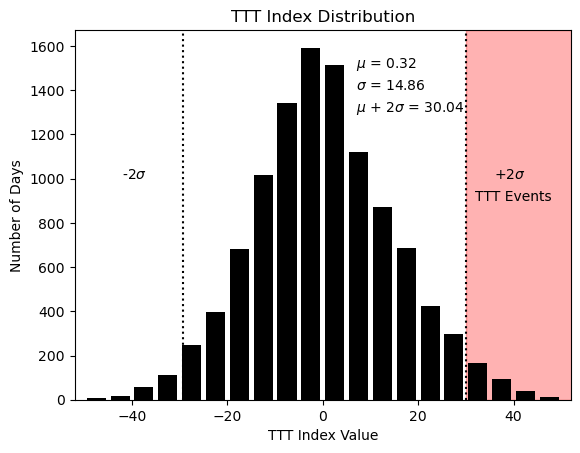

30.04159820481127


In [5]:

#make a histogram of the ttt index distribution
plt.hist(ttt_index,rwidth = 0.8,bins = np.arange(-50,54,5),color = 'k',zorder = 2)
plt.axvline(np.nanmean(ttt_index) + 2 * np.nanstd(ttt_index),color = 'k',linestyle = ':')
plt.axvline(np.nanmean(ttt_index) - 2 * np.nanstd(ttt_index),color = 'k',linestyle = ':')
plt.text(-42,1000,'-2$\sigma$')
plt.text(36,1000,'+2$\sigma$')
plt.text(32,900,'TTT Events')
plt.axvspan(np.nanmean(ttt_index) + 2 * np.nanstd(ttt_index),55, color = 'r',alpha = 0.3, zorder = 1)
plt.xlim(-52,52)
plt.xlabel('TTT Index Value')
plt.ylabel('Number of Days')
plt.title('TTT Index Distribution')
plt.text(7,1500,f'$\mu$ = {np.nanmean(ttt_index):.2f}')
plt.text(7,1400,f'$\sigma$ = {np.nanstd(ttt_index):.2f}')
plt.text(7,1300,f'$\mu$ + 2$\sigma$ = {np.nanmean(ttt_index) + 2*np.nanstd(ttt_index):.2f}')
plt.savefig(figure_path + 'TTT_INDEX_DISTRIBUTION.png')
plt.show()
print(np.nanmean(ttt_index) + 2 * np.nanstd(ttt_index))

In [6]:
#now load in the other data and refine it to just the peak of the TTT Events
#lets' start with the OLR
olr_ref_date = dt.datetime(1800,1,1)
os.chdir(data_path)
olr_file = Dataset('olr.day.mean.nc')
olr_clim_file = Dataset('olr.day.ltm.1981-2010.nc')
os.chdir(root)
olr_lon = olr_file.variables['lon'][:]
olr_lat = olr_file.variables['lat'][:]
olr_time = olr_file.variables['time'][:]
#refine the data to southern Africa (10N-40S,0E-80E)
lon_si = np.where(olr_lon == 0)[0][0]
lon_ei = np.where(olr_lon == 80)[0][0]
lat_si = np.where(olr_lat == 0)[0][0]
lat_ei = np.where(olr_lat == -50)[0][0]
olr_lat = olr_lat[lat_si:lat_ei]
olr_lon = olr_lon[lon_si:lon_ei]
#now pull in the data
olr_data = ma.getdata(olr_file.variables['olr'][:,lat_si:lat_ei,lon_si:lon_ei])
olr_dates = np.array([olr_ref_date + dt.timedelta(hours = time) for time in olr_time])



In [7]:
#pull in the climatology and subtract it to get anomalies
olr_clim = ma.getdata(olr_clim_file.variables['olr'][:,lat_si:lat_ei,lon_si:lon_ei])

def get_OLR_anomalies(olr_data:np.ndarray,olr_clim:np.ndarray,olr_dates:np.ndarray) -> np.ndarray:
    '''
        Calculate the OLR anomalies relative to the 1981-2010 mean and return
        them as an array.

        Returns the olr anomalies with shape (time,lat,lon)
    '''

    #make a ref date for the anomaly calculation
    ref_date = dt.datetime(2001,1,1)
    #convert olr dates to a pseudo 2001 state, Feb 29th becomes March 1st
    anom_dates = []
    for i in range(len(olr_dates)):
        if olr_dates[i].month == 2 and olr_dates[i].day == 29:
            anom_dates.append(dt.datetime(2001,3,1))
        else:
            anom_dates.append(dt.datetime(2001,olr_dates[i].month,olr_dates[i].day))
    #calculate the anomalies based on the correct day
    olr_anoms = olr_data[:]
    for i in range(len(olr_dates)):
        day_dif = (anom_dates[i] - ref_date).days
        olr_anoms[i] = olr_data[i] - olr_clim[day_dif]

    return olr_anoms

olr_anoms = get_OLR_anomalies(olr_data,olr_clim,olr_dates)

In [8]:
#let's limit to just TTT days
#first limit olr_dates to 1981-2022
olr_dates_ttt = olr_dates[np.where(olr_dates == dt.datetime(1979,1,1))[0][0]:]
olr_anom_ttt = olr_anoms[np.where(olr_dates == dt.datetime(1979,1,1))[0][0]:]
#now refine using ttt_bool
olr_dates_ttt = olr_dates_ttt[np.where(ttt_bool == 1)]
olr_anom_ttt = olr_anom_ttt[np.where(ttt_bool == 1),:,:][0,:,:]
olr_anom_ttt_composite = np.nanmean(olr_anom_ttt,axis = 0)

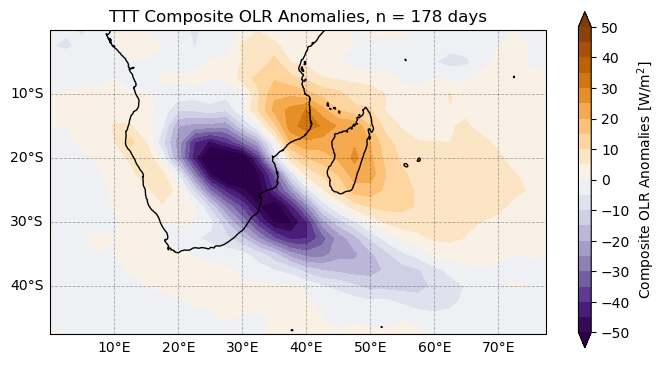

In [9]:
#now plot the composite
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(olr_lon,olr_lat,olr_anom_ttt_composite,levels = np.arange(-50,51,5),cmap = 'PuOr_r',extend = 'both')
plt.colorbar(cf,cax=cax,label = 'Composite OLR Anomalies [W/m$^2$]',ticks = np.arange(-50,55,10))
ax.set_title(f'TTT Composite OLR Anomalies, n = {int(np.sum(ttt_bool))} days')
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_OLR_COMP.png')
plt.show()

In [10]:
#let's plot the TTT seasonality to ensure it looks correct
mon_counter = [0,0,0,0,0,0,0,0]
for i in range(len(olr_dates_ttt)):
    if olr_dates_ttt[i].month == 10:
        mon_counter[0] +=1
    elif olr_dates_ttt[i].month == 11:
        mon_counter[1] += 1
    elif olr_dates_ttt[i].month == 12:
        mon_counter[2] += 1
    elif olr_dates_ttt[i].month == 1:
        mon_counter[3] += 1
    elif olr_dates_ttt[i].month == 2:
        mon_counter[4] += 1
    elif olr_dates_ttt[i].month == 3:
        mon_counter[5] += 1
    elif olr_dates_ttt[i].month == 4:
        mon_counter[6] += 1
    elif olr_dates_ttt[i].month == 5:
        mon_counter[7] += 1

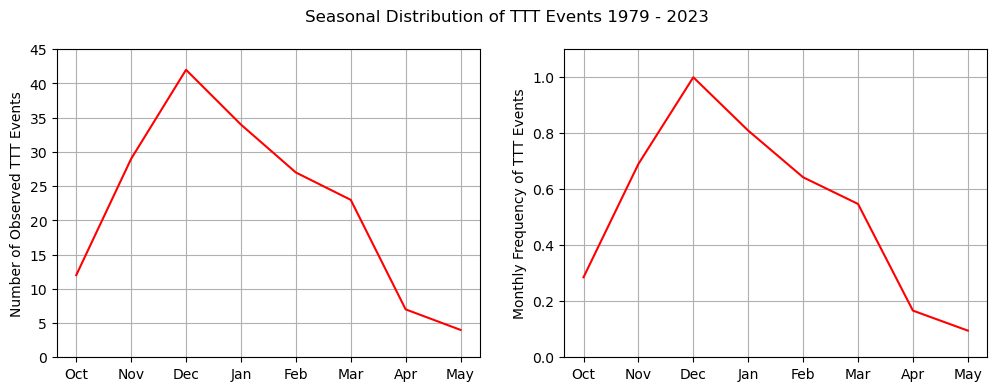

In [11]:
fig,ax = plt.subplots(1,2,figsize = (12,4))
ax[0].plot(mon_counter, color = 'r')
ax[0].set_ylabel('Number of Observed TTT Events')
ax[0].set_xticks([0,1,2,3,4,5,6,7],['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May'])
ax[0].set_ylim(0,45)
ax[0].grid()

ax[1].plot(np.array(mon_counter) / (2023-1981), color = 'r')
ax[1].set_ylabel('Monthly Frequency of TTT Events')
ax[1].set_xticks([0,1,2,3,4,5,6,7],['Oct','Nov','Dec','Jan','Feb','Mar','Apr','May'])
ax[1].set_ylim(0,1.1)
ax[1].grid()

plt.suptitle('Seasonal Distribution of TTT Events 1979 - 2023')
plt.savefig(figure_path + 'TTT_SEASONALITY.png')

plt.show()


In [12]:
#functions and constants for ERA5 data
era5_ref_date = dt.datetime(1900,1,1)

def make_era5_climatology(file:str,key:str) -> np.ndarray:
    '''
        Makes a daily climatology of ERA5 data for Austral Summer for
        a specified variable.

        file (str): The name of the .nc file containing the ERA5 data
        key (str): The key needed to access the data within the 
            specified .nc file

        returns the climatology as a numpy array
    '''
    #ref date to convert from time to date
    ref_date = dt.datetime(1900,1,1)

    #dates need to encompass austral summer, Feb 29th with be folded
    #into March 1st to handle leap days
    climatology_start_date = dt.datetime(2000,10,1)
    climatology_end_date = dt.datetime(2001,6,1)
    climatology_dates = np.array([climatology_start_date + dt.timedelta(days = dd) for dd in range((climatology_end_date - climatology_start_date).days)])

    climatology_array = np.zeros((len(climatology_dates),201,321))
    climatology_count = np.zeros((len(climatology_dates),201,321))
    #now I want to open up the .nc file and pull an element one at a time and put it
    #in the appropriate slot for the climatology
    os.chdir(data_path)
    file_time = Dataset(file).variables['time'][:]
    file_dates = np.array([ref_date + dt.timedelta(hours = int(hr)) for hr in file_time])
    for i in range(len(file_dates)):
        daily_data = Dataset(file).variables[key][i,:,:]
        #convert the date to a climatology date that is usable
        if file_dates[i].month >= 10:
            use_date = dt.datetime(2000,file_dates[i].month,file_dates[i].day)
        else:
            if file_dates[i].month == 2 and file_dates[i].day == 29:
                use_date = dt.datetime(2001,3,1)
            else:
                use_date = dt.datetime(2001,file_dates[i].month,file_dates[i].day)
        climatology_array[np.where(climatology_dates == use_date)[0][0]] += daily_data
        climatology_count[np.where(climatology_dates == use_date)[0][0]] += 1
    os.chdir(root)
    
    return climatology_array/climatology_count

def get_ERA5_anomalies(era5_data:np.ndarray,era5_clim:np.ndarray,era5_dates:np.ndarray) -> np.ndarray:
    '''
        Calculate the OLR anomalies relative to the 1981-2010 mean and return
        them as an array.

        Returns the olr anomalies with shape (time,lat,lon)
    '''

    #dates need to encompass austral summer, Feb 29th with be folded
    #into March 1st to handle leap days
    climatology_start_date = dt.datetime(2000,10,1)
    climatology_end_date = dt.datetime(2001,6,1)
    climatology_dates = np.array([climatology_start_date + dt.timedelta(days = dd) for dd in range((climatology_end_date - climatology_start_date).days)])

    #calculate the anomalies based on the correct day
    era5_anoms = np.empty(era5_data.shape)
    for i in range(len(era5_dates)):
        if era5_dates[i].month >= 10:
            use_date = dt.datetime(2000,era5_dates[i].month,era5_dates[i].day)
        else:
            if era5_dates[i].month == 2 and era5_dates[i].day == 29:
                use_date = dt.datetime(2001,3,1)
            else:
                use_date = dt.datetime(2001,era5_dates[i].month,era5_dates[i].day)
        day_ind = np.where(climatology_dates == use_date)[0][0]
        era5_anoms[i] = era5_data[i] - era5_clim[day_ind]
    return era5_anoms

In [13]:
# now let's start working on ERA5 composites
# first let's do surface pressure
os.chdir(data_path)
sp_file = Dataset('ERA5_surfP.nc')
os.chdir(root)
sp_file.variables.keys()
sp_lats = sp_file.variables['latitude'][:]
sp_lons = sp_file.variables['longitude'][:]
sp_time = sp_file.variables['time'][:]
#convert time to dates
sp_dates = np.array([era5_ref_date + dt.timedelta(hours = int(hr)) for hr in sp_time])
#find the indices where the sp_dates matches TTT dates
era5_ttt_inds = []
for i in range(len(olr_dates_ttt)):
    era5_ttt_inds.append(np.where(sp_dates == (olr_dates_ttt[i] + dt.timedelta(hours = 12)))[0][0])
era5_ttt_inds = np.array(era5_ttt_inds)
#now just get the sp data for those dates
sp_data = sp_file.variables['sp'][era5_ttt_inds,:,:]
sp_file.close()

In [14]:
#now let's get the other variables
os.chdir(data_path)
q850_data = Dataset('ERA5_q850.nc').variables['q'][era5_ttt_inds,:,:]
z200_data = Dataset('ERA5_z200.nc').variables['z'][era5_ttt_inds,:,:]
u850_data = Dataset('ERA5_u850.nc').variables['u'][era5_ttt_inds,:,:]
v850_data = Dataset('ERA5_v850.nc').variables['v'][era5_ttt_inds,:,:]
v500_data = Dataset('ERA5_v500.nc').variables['v'][era5_ttt_inds,:,:]
u500_data = Dataset('ERA5_u500.nc').variables['u'][era5_ttt_inds,:,:]
w500_data = Dataset('ERA5_w500.nc').variables['w'][era5_ttt_inds,:,:]
os.chdir(root)

In [15]:
#now let's get climatology for those variables
q850_clim = make_era5_climatology('ERA5_q850.nc','q')
z200_clim = make_era5_climatology('ERA5_z200.nc','z')
u850_clim = make_era5_climatology('ERA5_u850.nc','u')
v850_clim = make_era5_climatology('ERA5_v850.nc','v')
u500_clim = make_era5_climatology('ERA5_u500.nc','u')
v500_clim = make_era5_climatology('ERA5_v500.nc','v')
w500_clim = make_era5_climatology('ERA5_w500.nc','w')
sp_clim = make_era5_climatology('ERA5_surfP.nc','sp')
tot_wind_clim = np.sqrt(u850_clim**2 + v850_clim**2)

In [16]:
#now the anomalies for the era5 data
sp_anoms = get_ERA5_anomalies(sp_data,sp_clim,sp_dates[era5_ttt_inds])
q850_anoms = get_ERA5_anomalies(q850_data,q850_clim,sp_dates[era5_ttt_inds])
z200_anoms = get_ERA5_anomalies(z200_data,z200_clim,sp_dates[era5_ttt_inds])
u850_anoms = get_ERA5_anomalies(u850_data,u850_clim,sp_dates[era5_ttt_inds])
v850_anoms = get_ERA5_anomalies(v850_data,v850_clim,sp_dates[era5_ttt_inds])
u500_anoms = get_ERA5_anomalies(u500_data,u500_clim,sp_dates[era5_ttt_inds])
v500_anoms = get_ERA5_anomalies(v500_data,v500_clim,sp_dates[era5_ttt_inds])
w500_anoms = get_ERA5_anomalies(w500_data,w500_clim,sp_dates[era5_ttt_inds])
tot_wind_anoms = get_ERA5_anomalies(np.sqrt(u850_data**2 + v850_data**2),tot_wind_clim,sp_dates[era5_ttt_inds])


In [17]:
#make composites of all the era5 data
sp_comp = np.nanmean(sp_anoms,axis = 0)
q850_comp = np.nanmean(q850_anoms,axis = 0)
z200_comp = np.nanmean(z200_anoms,axis = 0)
u850_comp = np.nanmean(u850_anoms,axis = 0)
v850_comp = np.nanmean(v850_anoms,axis = 0)
u500_comp = np.nanmean(u500_anoms,axis = 0)
v500_comp = np.nanmean(v500_anoms,axis = 0)
w500_comp = np.nanmean(w500_anoms,axis = 0)
tot_wind_comp = np.nanmean(tot_wind_anoms,axis = 0)

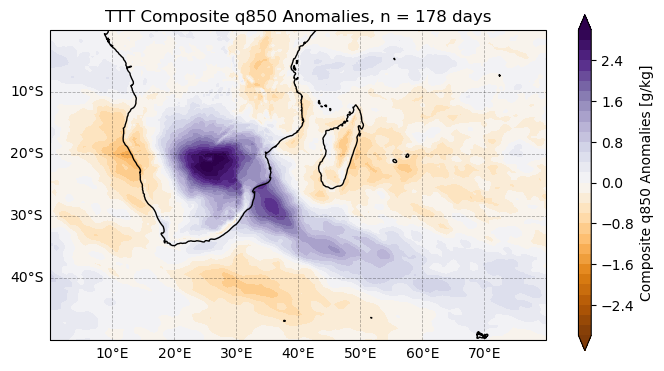

In [18]:
#now plot the composite
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(sp_lons,sp_lats,q850_comp*1000,cmap = 'PuOr',levels = np.arange(-3,3.1,0.2),extend = 'both')
plt.colorbar(cf,cax=cax,label = 'Composite q850 Anomalies [g/kg]')
ax.set_title(f'TTT Composite q850 Anomalies, n = {int(np.sum(ttt_bool))} days')
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_Q850_COMP.png')
plt.show()

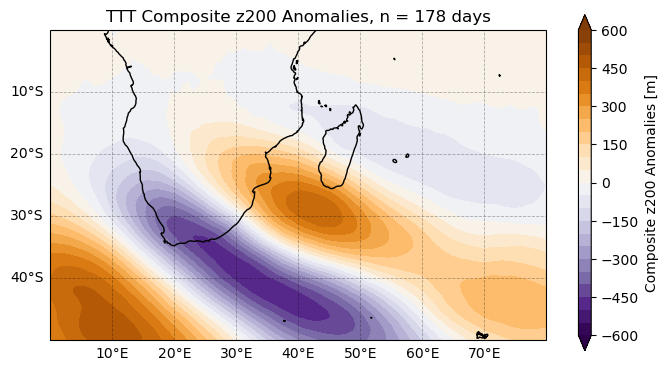

In [19]:
#now plot the composite
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(sp_lons,sp_lats,z200_comp,cmap = 'PuOr_r',levels = np.arange(-600,610,50),extend = 'both')
plt.colorbar(cf,cax=cax,label = 'Composite z200 Anomalies [m]')
ax.set_title(f'TTT Composite z200 Anomalies, n = {int(np.sum(ttt_bool))} days')
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_Z200_COMP.png')
plt.show()

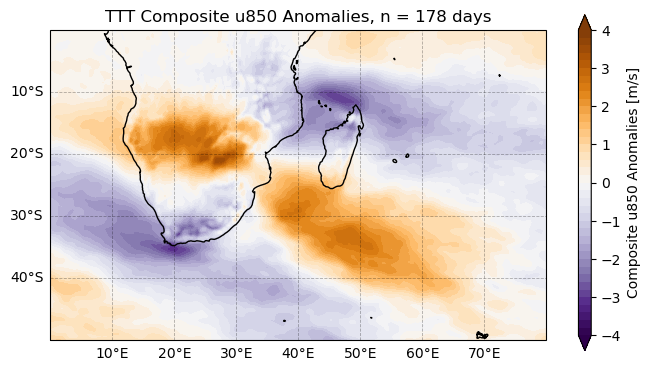

In [20]:
quiv_step = 10
#now plot the composite
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
divnorm=colors.TwoSlopeNorm(vmin=-4., vcenter=0., vmax=4)
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(sp_lons,sp_lats,u850_comp,cmap = 'PuOr_r',levels = np.arange(-4,4.1,.2),extend = 'both',norm = divnorm)
#ax.quiver(sp_lons[::quiv_step],sp_lats[::quiv_step],u850_comp[::quiv_step,::quiv_step],v850_comp[::quiv_step,::quiv_step])
plt.colorbar(cf,cax=cax,label = 'Composite u850 Anomalies [m/s]')
ax.set_title(f'TTT Composite u850 Anomalies, n = {int(np.sum(ttt_bool))} days')
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_U850_COMP.png')
plt.show()

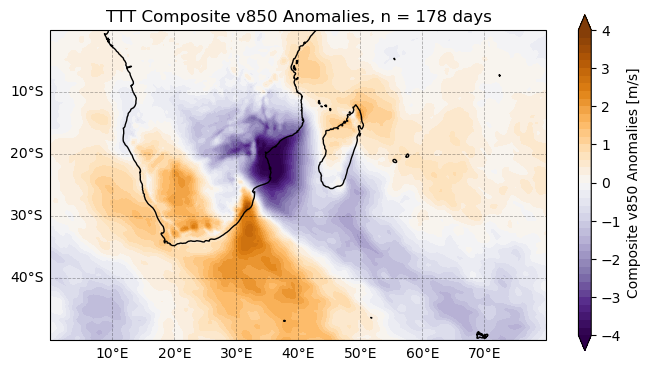

In [21]:
quiv_step = 10
#now plot the composite
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
divnorm=colors.TwoSlopeNorm(vmin=-4., vcenter=0., vmax=4)
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(sp_lons,sp_lats,v850_comp,cmap = 'PuOr_r',levels = np.arange(-4,4.1,.2),extend = 'both',norm = divnorm)
#ax.quiver(sp_lons[::quiv_step],sp_lats[::quiv_step],u850_comp[::quiv_step,::quiv_step],v850_comp[::quiv_step,::quiv_step])
plt.colorbar(cf,cax=cax,label = 'Composite v850 Anomalies [m/s]')
ax.set_title(f'TTT Composite v850 Anomalies, n = {int(np.sum(ttt_bool))} days')
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_V850_COMP.png')
plt.show()

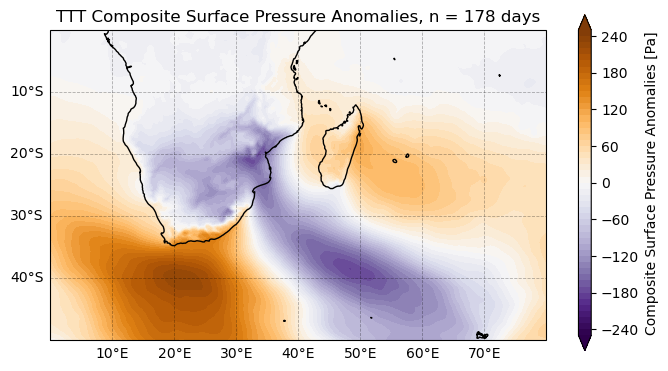

In [22]:
quiv_step = 10
#now plot the composite
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
divnorm=colors.TwoSlopeNorm(vmin=-4., vcenter=0., vmax=4)
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(sp_lons,sp_lats,sp_comp,cmap = 'PuOr_r',extend = 'both',levels = np.arange(-250,251,10))
#ax.quiver(sp_lons[::quiv_step],sp_lats[::quiv_step],u850_comp[::quiv_step,::quiv_step],v850_comp[::quiv_step,::quiv_step])
plt.colorbar(cf,cax=cax,label = 'Composite Surface Pressure Anomalies [Pa]')
ax.set_title(f'TTT Composite Surface Pressure Anomalies, n = {int(np.sum(ttt_bool))} days')
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_SURFP_COMP.png')
plt.show()

In [23]:
os.chdir(root)

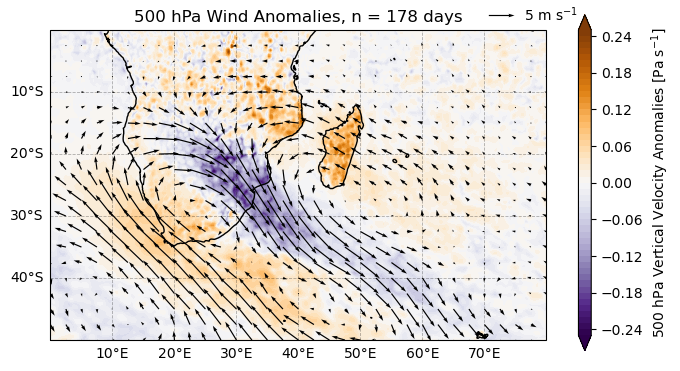

In [24]:
quiv_step = 10
#now plot the composite
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()})
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
divnorm=colors.TwoSlopeNorm(vmin=-4., vcenter=0., vmax=4)
#ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
cf = ax.contourf(sp_lons,sp_lats,w500_comp,cmap = 'PuOr_r',extend = 'both',levels = np.arange(-0.25,0.26,.01))
q = ax.quiver(sp_lons[::quiv_step],sp_lats[::quiv_step],u500_comp[::quiv_step,::quiv_step],v500_comp[::quiv_step,::quiv_step],units='width')
ax.quiverkey(q,0.85,0.85,5,'5 m s$^{-1}$',labelpos='E',coordinates='figure',transform=ccrs.PlateCarree(),color = 'k')
plt.colorbar(cf,cax=cax,label = '500 hPa Vertical Velocity Anomalies [Pa s$^{-1}$]')
ax.set_title(f'500 hPa Wind Anomalies, n = {int(np.sum(ttt_bool))} days')
gl = ax.gridlines(draw_labels=True, linewidth=0.6, alpha=0.3, color='k',linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.savefig(figure_path + 'TTT_500_WIND_ANOMALIES.png')
plt.show()